PART A

1. Importing and Understanding Data

In [1]:
import os
import cv2
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC
from tqdm.notebook import tqdm

from zipfile import ZipFile
import tensorflow
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing and reading 'images.npy'
data = np.load("C:/Users/ruhee/OneDrive/Desktop/AIML/Computer Vision/images (1).npy", allow_pickle = True)

In [3]:
data.shape

(409, 2)

In [4]:
data[0].shape

(2,)

In [5]:
data[0]

array([array([[[42, 37, 34],
               [56, 51, 48],
               [71, 66, 63],
               ...,
               [23, 33, 34],
               [26, 36, 37],
               [28, 38, 39]],

              [[40, 35, 32],
               [51, 46, 43],
               [64, 59, 56],
               ...,
               [27, 36, 35],
               [24, 33, 32],
               [26, 35, 34]],

              [[43, 38, 35],
               [51, 46, 43],
               [61, 56, 53],
               ...,
               [28, 30, 27],
               [33, 35, 32],
               [35, 37, 34]],

              ...,

              [[56, 47, 40],
               [57, 48, 41],
               [61, 52, 45],
               ...,
               [67, 48, 42],
               [55, 35, 28],
               [60, 40, 33]],

              [[53, 44, 37],
               [54, 45, 38],
               [57, 48, 41],
               ...,
               [59, 40, 34],
               [60, 40, 33],
               [54, 34, 27]],



In [6]:
data[0][0].shape

(333, 650, 3)

In [7]:
data[0][0]

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)

In [8]:
data[0][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
  'imageWidth': 650,
  'imageHeight': 333},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}],
  'imageWidth': 650,
  'imageHeight': 333}]

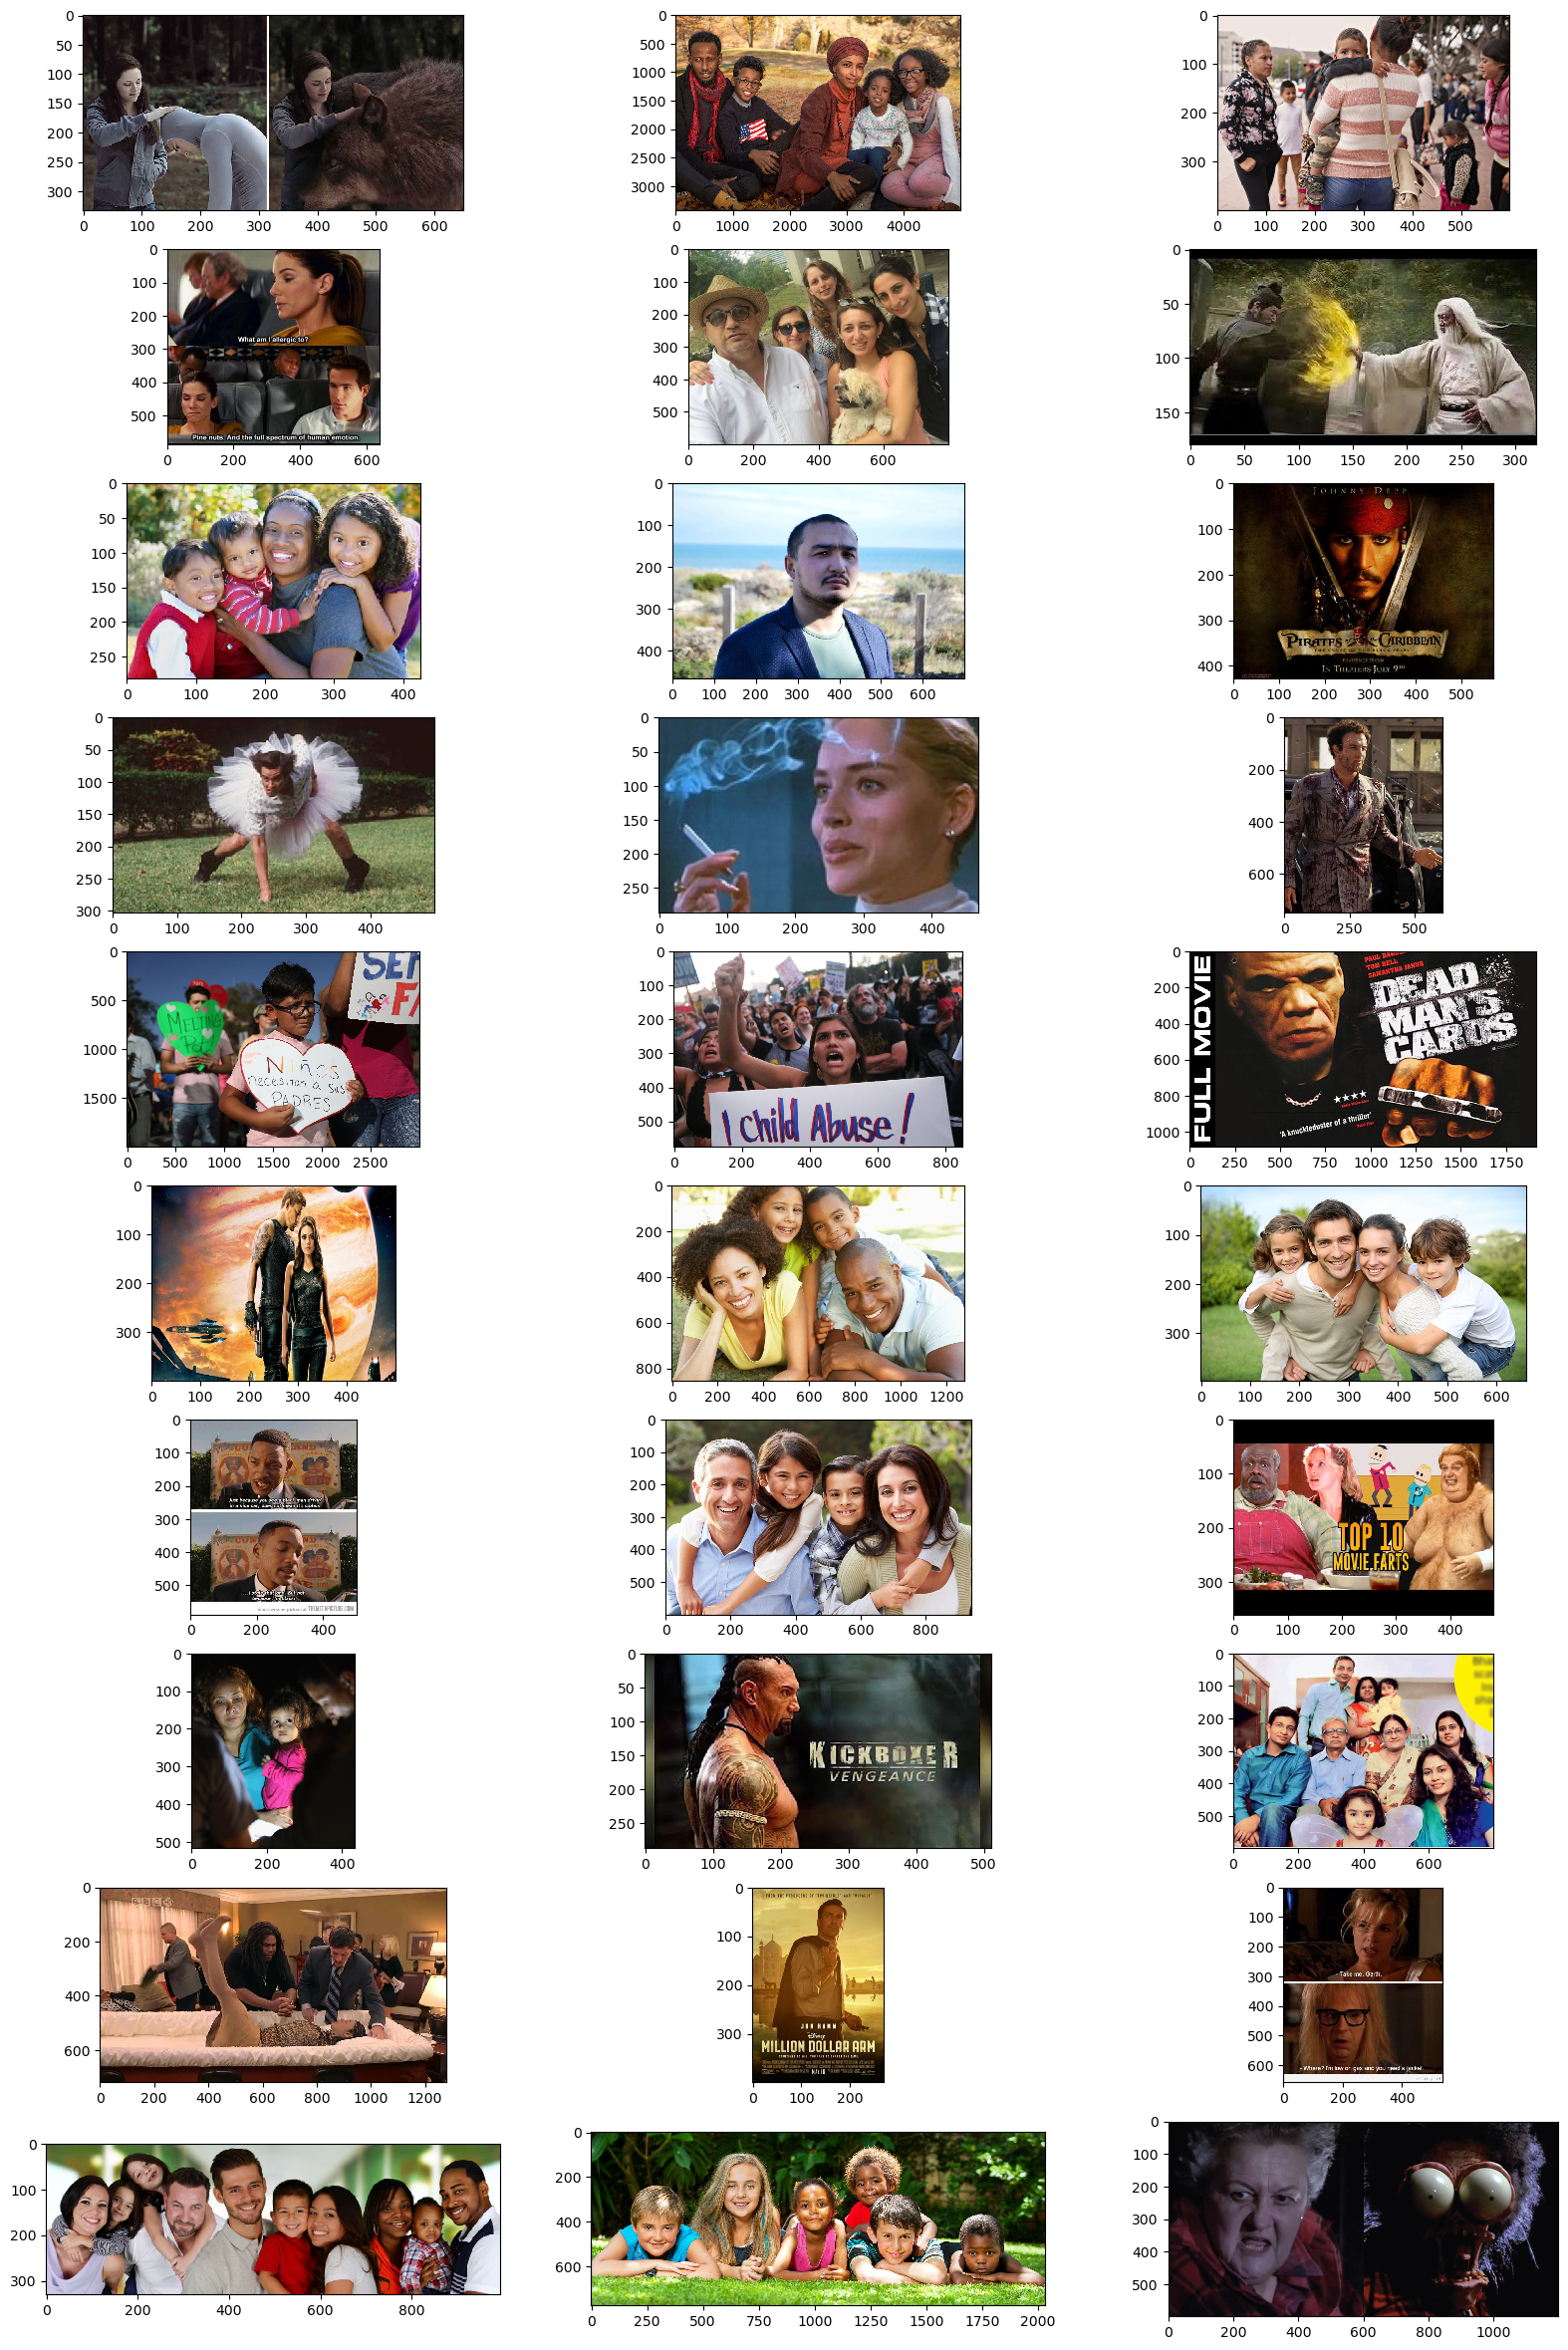

In [9]:
# Checking the images in the dataset
fi,ax = plt.subplots(10,3,figsize = (20,30))
row = 0
col = 0
index = 0
for i in range(30):
  ax[row][col].imshow(data[index][0], interpolation = 'nearest')
  index = index + 12
  col = col + 1
  if col > 2:
    row = row + 1
    col = 0
plt.show()

In [10]:
# Creating features and labels
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 128

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]),IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(data.shape[0]):
  img = data[index][0]
  img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
  try:
    img = img[:,:,:3]
  except:
    print(f"Exception {index} Grayscale image with shape {img.shape}")
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))
  for i in data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
    masks[index][y1:y2, x1:x2] = 1
print(f"Shape of X is '{X.shape}' and the shape of mask is '{masks.shape}' ")

Exception 272 Grayscale image with shape (128, 128)
Shape of X is '(409, 128, 128, 3)' and the shape of mask is '(409, 128, 128)' 


In [11]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size = 0.22)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.22)

print(f"Shape of X_train is '{X_train.shape}' and the shape of y_train is '{y_train.shape}'")
print(f"Shape of X_val is '{X_val.shape}' and the shape of y_val is '{y_val.shape}'")
print(f"Shape of X_test is '{X_test.shape}' and the shape of y_test is '{y_test.shape}'")

Shape of X_train is '(319, 128, 128, 3)' and the shape of y_train is '(319, 128, 128)'
Shape of X_val is '(70, 128, 128, 3)' and the shape of y_val is '(70, 128, 128)'
Shape of X_test is '(20, 128, 128, 3)' and the shape of y_test is '(20, 128, 128)'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


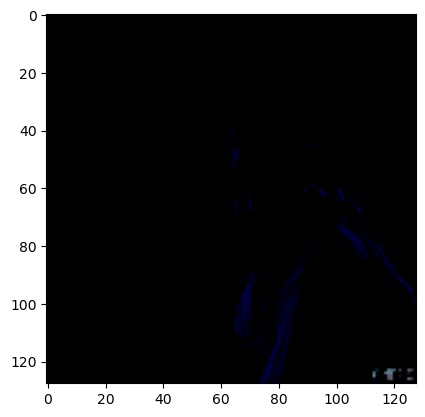

In [12]:
# Selecting a random image from train image and displaying the original image
plt.imshow(X_train[2])

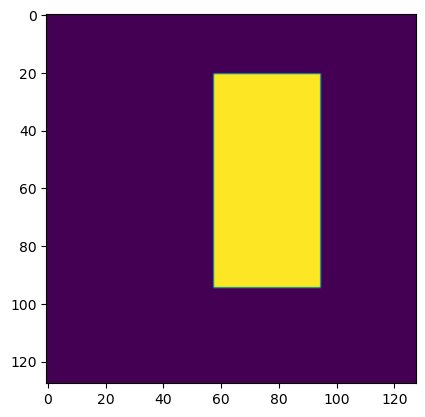

In [13]:
# Displaying the masked image
plt.imshow(y_train[2])

2. Model Building

In [14]:
# Creating a face mask detection model
IMAGE_SIZE = 128
ALPHA = 1
EPOCHS = 30
BATCH = 8
LR = 1e-4

In [15]:
model = MobileNet(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, alpha = ALPHA, weights = "imagenet")
model.summary()



Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 64, 64, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 64, 64, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 64, 64, 32

In [16]:
def create_model(trainable = False):
    model = MobileNet(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, alpha = ALPHA, weights = "imagenet")
    
    for layer in model.layers:
        layer.trainable = trainable
        
    block00 = model.layers[0].input
    block01 = model.get_layer("conv_pw_1_relu").output
    block02 = model.get_layer("conv_pw_2_relu").output
    block03 = model.get_layer("conv_pw_3_relu").output
    block05 = model.get_layer("conv_pw_5_relu").output
    block11 = model.get_layer("conv_pw_11_relu").output
    block13 = model.get_layer("conv_pw_13_relu").output
    
    decoderBlock = Concatenate()([UpSampling2D()(block13), block11])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block05])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block03])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block01])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block00])

    decoderBlock = Conv2D(1, kernel_size = 1, activation = "sigmoid")(decoderBlock)
    decoderBlock = Reshape((IMAGE_SIZE, IMAGE_SIZE))(decoderBlock)

    return Model(inputs = model.input, outputs = decoderBlock)

In [17]:
model = create_model(False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 32)           128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['conv1_bn[0][0]']        

In [18]:
# Defining dice coefficient
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [19]:
# Defining loss function
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [20]:
optimizer = optimizer = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coefficient, Recall(), Precision()]
model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

In [21]:
callbacks = [ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4),
            EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = False)]

In [22]:
train_steps = len(X_train)//BATCH
valid_steps = len(X_val)//BATCH

if len(X_train) % BATCH != 0:
    train_steps += 1
if len(X_val) % BATCH != 0:
    valid_steps += 1

model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = EPOCHS, steps_per_epoch = train_steps,
          validation_steps = valid_steps, callbacks = callbacks)

Epoch 1/30


40/40 [==============================] - 48s 1s/step - loss: 2.0901 - dice_coefficient: 0.2267 - recall: 0.3654 - precision: 0.1904 - val_loss: 2.0184 - val_dice_coefficient: 0.2236 - val_recall: 0.3477 - val_precision: 0.2252 - lr: 1.0000e-04
Epoch 2/30
40/40 [==============================] - 35s 879ms/step - loss: 1.7497 - dice_coefficient: 0.2776 - recall: 0.3821 - precision: 0.3065 - val_loss: 1.7228 - val_dice_coefficient: 0.2760 - val_recall: 0.4107 - val_precision: 0.3084 - lr: 1.0000e-04
Epoch 3/30
40/40 [==============================] - 35s 870ms/step - loss: 1.5342 - dice_coefficient: 0.3253 - recall: 0.4469 - precision: 0.3970 - val_loss: 1.5193 - val_dice_coefficient: 0.3155 - val_recall: 0.4074 - val_precision: 0.3924 - lr: 1.0000e-04
Epoch 4/30
40/40 [==============================] - 34s 853ms/step - loss: 1.3393 - dice_coefficient: 0.3727 - recall: 0.4817 - precision: 0.4664 - val_loss: 1.3800 - val_dice_coefficient: 0.3497 - val_recall: 0.4244 - val_prec

In [23]:
test_steps = (len(X_test)//BATCH)
if len(X_test) % BATCH != 0:
    test_steps += 1

model.evaluate(X_test, y_test, steps = test_steps)

3/3 [==============================] - 2s 519ms/step - loss: 0.8766 - dice_coefficient: 0.5747 - recall: 0.6911 - precision: 0.5668


[0.8766239285469055,
 0.5747478604316711,
 0.6911271214485168,
 0.5668086409568787]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


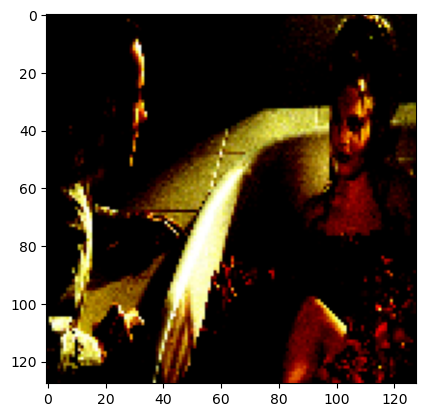

In [24]:
n = 3
test_image = X_train[n]
print(test_image.shape)
plt.imshow(test_image)

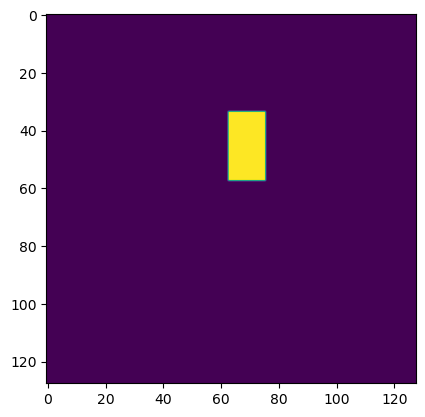

In [25]:
test_mask = masks[n]
plt.imshow(test_mask)

1/1 [==============================] - 1s 827ms/step


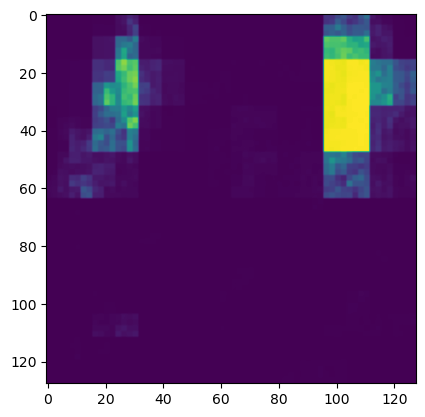

In [26]:
test_image = np.resize(test_image, (1, 128, 128, 3))
pred_mask = model.predict(x = test_image)
pred_mask = np.resize(pred_mask, (128, 128))
plt.imshow(pred_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


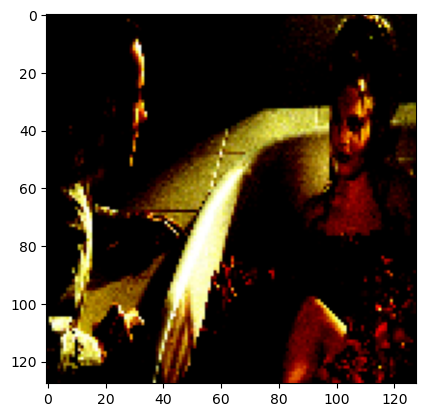

In [27]:
final_pred_mask = np.resize(pred_mask, (128, 128))
final_image = np.resize(test_image, (128, 128, 3))
plt.imshow(final_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


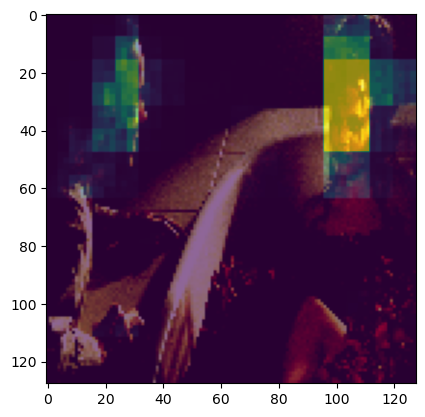

In [28]:
fig = plt.figure()
img_1 = plt.imshow(final_image)
img_2 = plt.imshow(final_pred_mask, alpha = 0.6)
plt.show()

PART B

In [34]:
import cv2
import glob
import os
import pandas as pd
from zipfile import ZipFile

# Extract images from the zip file
zip_file_path = "C:/Users/ruhee/OneDrive/Desktop/AIML/Computer Vision/training_images-20211126T092819Z-001.zip"
extract_path = "C:/Users/ruhee/OneDrive/Desktop/AIML/Computer Vision/Part B"

with ZipFile(zip_file_path, 'r') as zip:
    zip.extractall(extract_path)

# Load the face cascade
cascPath = "haarcascade_frontalface_alt2.xml"
faceCascade = cv2.CascadeClassifier(cascPath)

# Create a list to store face metadata
face_metadata_list = []

# Process each image in the extracted folder
image_folder = os.path.join(extract_path, "*.jpg")
for image_path in glob.glob(image_folder):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = faceCascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=4, minSize=(30, 30))
    print("Found {0} faces in {1}".format(len(faces), image_path))

    # Crop Padding
    left = 10
    right = 10
    top = 10
    bottom = 10

    # Process each detected face
    for (x, y, w, h) in faces:
        print("Face coordinates:", x, y, w, h)

        # Extract metadata
        file_name = os.path.basename(image_path)
        face_metadata = {
            "Image": file_name,
            "X": x,
            "Y": y,
            "Width": w,
            "Height": h,
        }

        # Append metadata to the list
        face_metadata_list.append(face_metadata)

        # Save cropped image
        cropped_image = image[y - top : y + h + bottom, x - left : x + w + right]
        cropped_file_path = os.path.join(extract_path, "cropped_{0}_{1}.jpg".format(str(file_name), str(x)))
        cv2.imwrite(cropped_file_path, cropped_image)
        print("Saved:", cropped_file_path)

# Convert the list of face metadata to a DataFrame
df_faces = pd.DataFrame(face_metadata_list)

# Save the DataFrame to a CSV file
csv_file_path = "face_metadata.csv"
df_faces.to_csv(csv_file_path, index=False)

# Display the DataFrame
print("DataFrame saved to:", csv_file_path)


DataFrame saved to: face_metadata.csv


PART C

In [30]:
with ZipFile("C:/Users/ruhee/OneDrive/Desktop/AIML/Computer Vision/PINS.zip", 'r') as zip:
    zip.extractall()

In [31]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 

In [32]:
def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

In [33]:
metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

In [34]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [35]:
load_image(metadata[0].image_path())

array([[[233, 188, 165],
        [231, 186, 163],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[232, 187, 164],
        [233, 188, 165],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[230, 186, 161],
        [228, 184, 159],
        [206, 164, 140],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       ...,

       [[198, 118,  91],
        [197, 120,  94],
        [195, 119,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[200, 120,  93],
        [200, 120,  93],
        [198, 121,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[201, 121,  94],
        [201, 121,  94],
        [199, 122,  96],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]]

In [36]:
def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape = (224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides = (2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides = (2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides = (2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides = (2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides = (2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [37]:
model = vgg_face()
model.load_weights("C:/Users/ruhee/OneDrive/Desktop/AIML/Computer Vision/vgg_face_weights.h5")
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 226, 226, 3)       0         
 g2D)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 226, 226, 64)      0         
 ing2D)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                        

In [38]:
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)

In [39]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 1s 1s/step
(2622,)


In [40]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

0it [00:00, ?it/s]

1/1 [==============================] - 1s 500ms/step


In [41]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

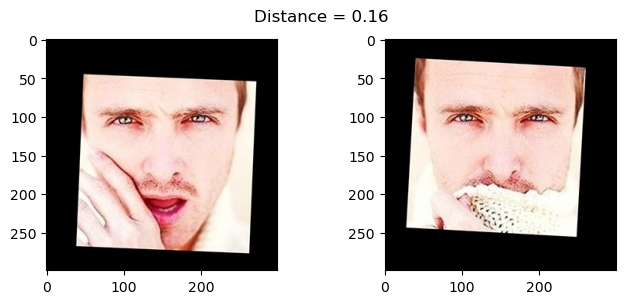

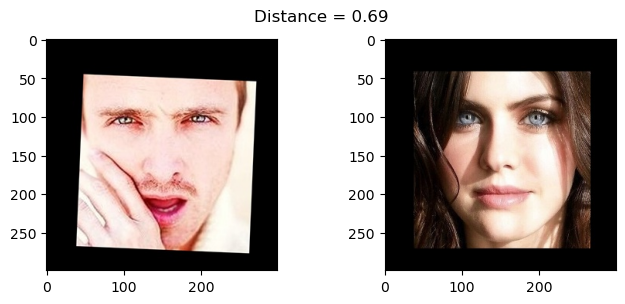

In [42]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

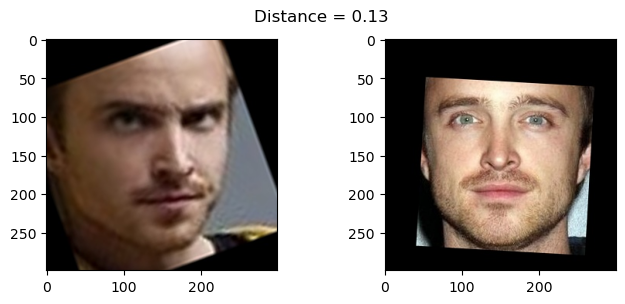

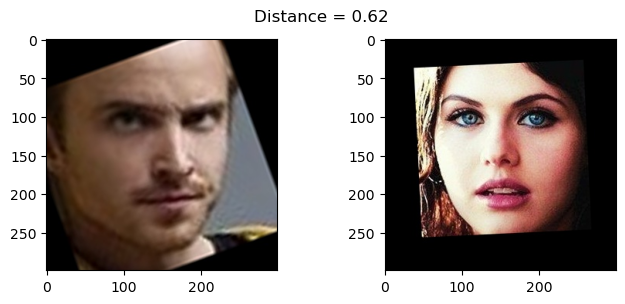

In [43]:
show_pair(30, 31)
show_pair(30, 100)

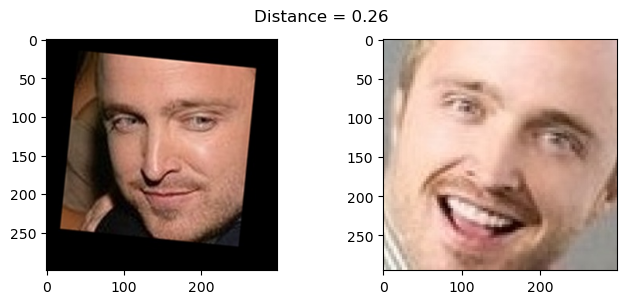

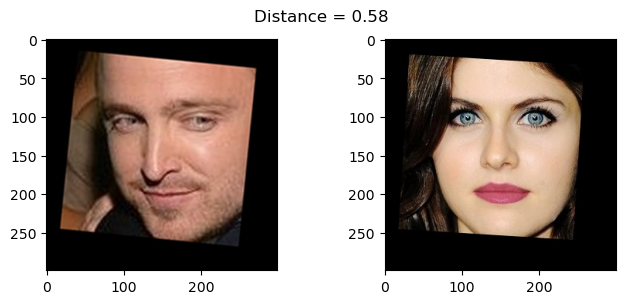

In [44]:
show_pair(70, 72)
show_pair(70, 115)

In [45]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

In [46]:
from sklearn.preprocessing import LabelEncoder
# Encode labels
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

In [47]:
from sklearn.preprocessing import StandardScaler
# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [48]:
# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.58416799  18.9486785   22.94242518 ...  99.99999983  99.99999999
 100.        ]


In [49]:
# Get index where cumulative variance explained is > threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

Index of element just greater than 95: 346


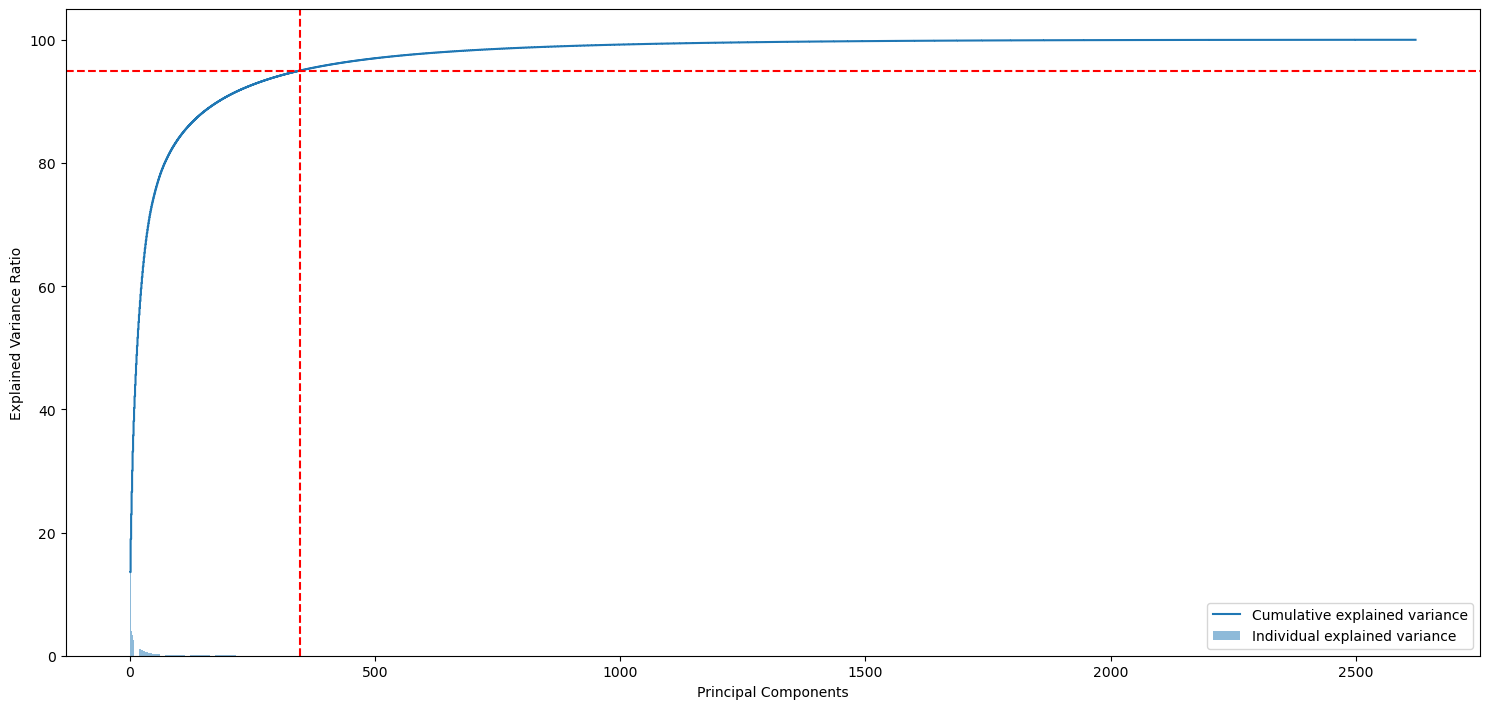

In [50]:
# Ploting 
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [51]:
# Reducing the dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components = index, random_state = 50, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 346)

(1197, 346)

In [52]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'class_weight': ['balanced', None]}]
svc = GridSearchCV(SVC(random_state = 50), params_grid, cv = 3, scoring = 'f1_macro', verbose = 50, n_jobs = -1)
svc.fit(X_train_pca, y_train)

print('Best estimator found by grid search:')
print(svc.best_estimator_)

# Best estimator found by grid search:
SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced')

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best estimator found by grid search:
SVC(C=10, class_weight='balanced', gamma=0.0001, random_state=50)


SVC(C=1, class_weight='balanced', gamma=0.001)

In [53]:
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = 50)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.994


In [54]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.966


In [55]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       0.91      1.00      0.95        10
            Alvaro Morte       1.00      1.00      1.00        14
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       1.00      0.89      0.94         9
        Amber Heard Face       1.00      1.00      1.00         7
               Anna Gunn       1.00      1.00      1.00        14
           Anne Hathaway       1.00      1.00      1.00        14
     Barbara Palvin Face       1.00      1.00      1.00         9
      Bellamy Blake Face       0.87      0.93      0.90        14
    Benedict Cumberbatch       1.00      1.00      1.00        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       1.00      0.90      

In [56]:
test_image1 = load_image("C:/Users/ruhee/OneDrive/Desktop/AIML/Computer Vision/Benedict+Cumberbatch9.jpg")
test_image1 = (test_image1/255.).astype(np.float32)
test_image1 = cv2.resize(test_image1, dsize = (224, 224))

In [57]:
embedding = vgg_face_descriptor.predict(np.expand_dims(test_image1, axis = 0))[0]
embedding_scaled = sc.transform(embedding.reshape(1, -1))
test1_pred = svc_pca.predict(pca.transform(embedding_scaled))
test1_pred_encoded = en.inverse_transform(test1_pred)

1/1 [==============================] - 1s 510ms/step


['pins_Benedict Cumberbatch']


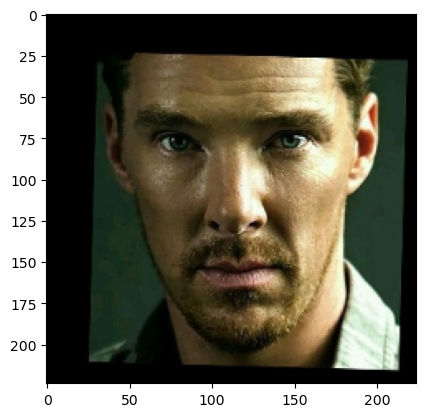

In [58]:
print(test1_pred_encoded)
plt.imshow(test_image1)

In [59]:
test_image2 = load_image("C:/Users/ruhee/OneDrive/Desktop/AIML/Computer Vision/Dwayne+Johnson4.jpg")
test_image2 = (test_image2/255.).astype(np.float32)
test_image2 = cv2.resize(test_image2, dsize = (224, 224))

In [60]:
embedding = vgg_face_descriptor.predict(np.expand_dims(test_image2, axis = 0))[0]
embedding_scaled = sc.transform(embedding.reshape(1, -1))
test2_pred = svc_pca.predict(pca.transform(embedding_scaled))
test2_pred_encoded = en.inverse_transform(test2_pred)

1/1 [==============================] - 0s 492ms/step


['pins_Dwayne Johnson']


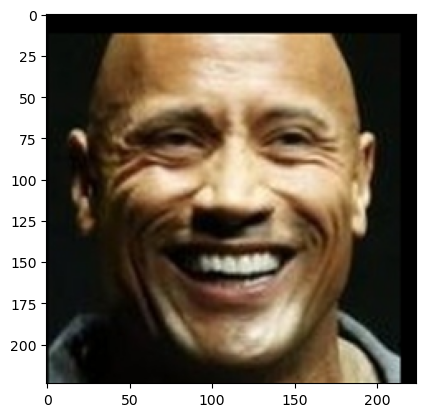

In [61]:
print(test2_pred_encoded)
plt.imshow(test_image2)